In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from scipy import stats
import scipy as sc
import seaborn as sns

En este notebook se plantea un analísis exploratorio de datos con respecto a ciertas caracteristicas de las llamaradas solares, las cuales son duración, posición en x, posición en y las cuales mostrarón tener cierta afinidad con las distribuciónes chi cuadrada en el caso de la duración y la distribucion normal en el caso de las posicion x,y. Sin embargo al realizar los ajustes se tienen densidades de probabilidad con valores muy bajos, ademas de que muchas pruebas de hipotesis realizadas con respecto a la duración no se ajustan a los datos. Esto se debe a que se tienen algunas relaciones que a pesar de no seguir una ley de potencias si tienen relaciones causales (en el caso de los rangos de emisiones de rayos X de bajas y altas energias). Sin embargo con la prueba F de fisher se pueden tener valores interpretables con respecto a la hipotesis nula que las varianzas tienen una proporcion 1 osea $$\frac{\sigma_{1}}{\sigma_{2}}=1$$
A continuación se comienza realizando un ajuste al formato de la fecha de todos los eventos, con un DateTime

In [377]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom

'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

def filtrof(data, Lbanderas): # Filtro por bandera
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
#print(dffiltro.value_counts('flag.2'))

en la siguiente celda se filtran las banderas para un analisis 'filtrado' que se hará en futuras celdas, ademas se hacen dataframes sin filtrar en los rangos de energia 6-12, 12-25, 25-50, 50-100 para el analisis de la variable duration.s, también se realiza un boxplot de la duracion con respecto a las energias), se puede observar que todas tienen medias distintas ademas de una cantidad seria de outliers, y uno podria tratar de eliminar los outliers pero se estaria perdiendo algo muy interesante con respecto a la varianza de estos resultados cuyas proporciones se prueban más adelante

Text(0.5, 1.0, 'Boxplot')

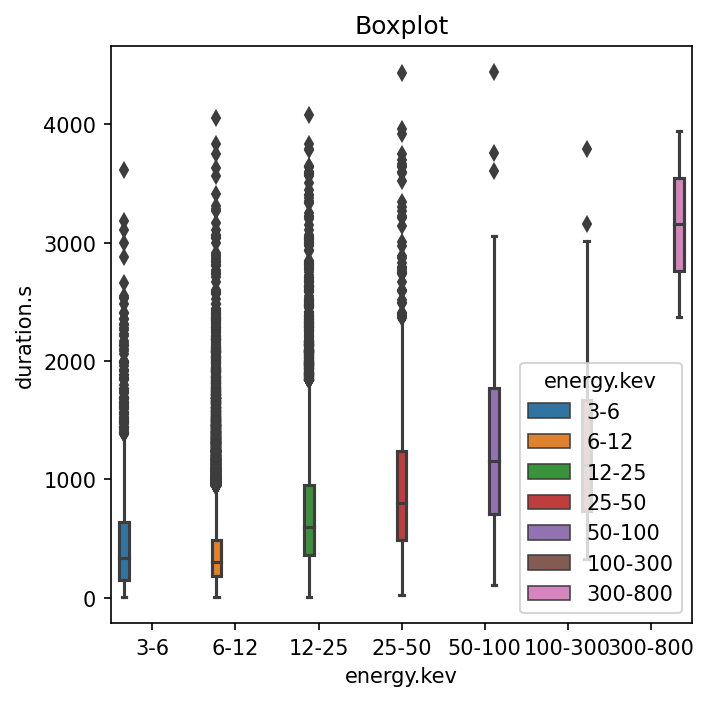

In [436]:
df['duration.ls']=np.log(df['duration.s'])
lista=['NS','PE','P0']
dffiltro=filtrof(df,lista)
#df['energy.kev'].value_counts()
energy1 = Filtro(df,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(df,'energy.kev','12-25')
energy3 = Filtro(df,'energy.kev','25-50')
energy4 = Filtro(df,'energy.kev','50-100')
#dfe=pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
#dfdt = dfe['duration.s']
#dfep = dfe['EnergiaProm']
#datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
plt.figure(figsize=(5,5), dpi = 150)
sns.boxplot(data=dffiltro.sort_values('EnergiaProm'),x='energy.kev',y='duration.s',hue='energy.kev')
plt.title('Boxplot')

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

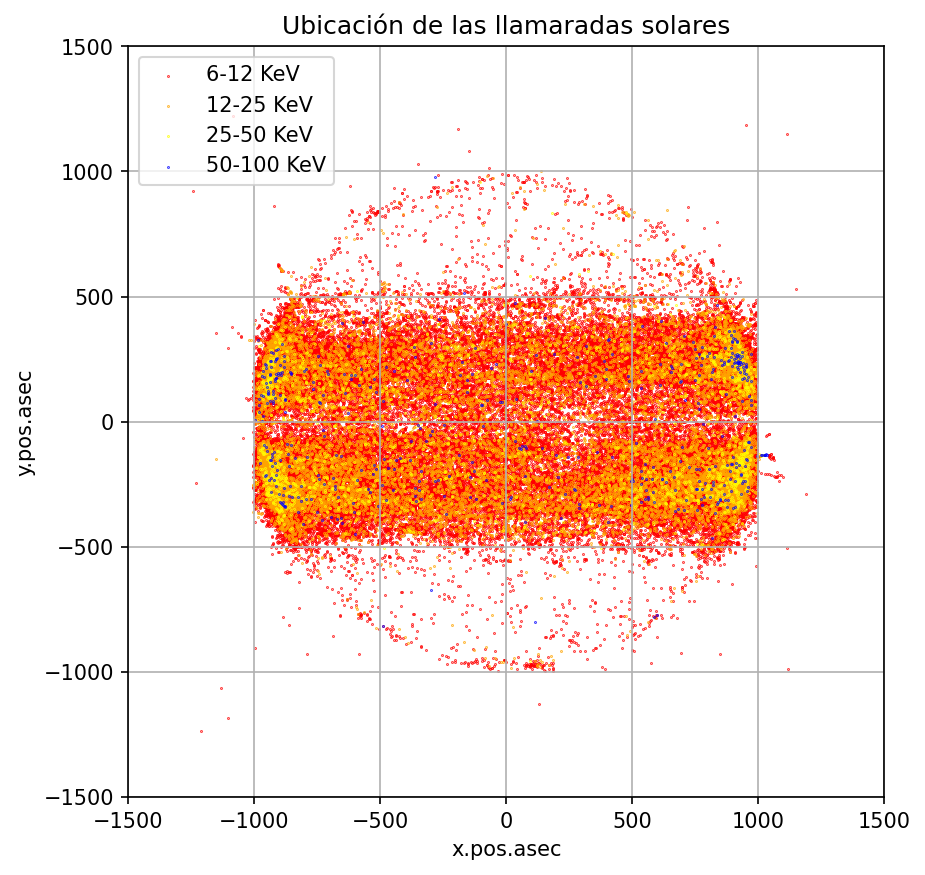

In [437]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
\textbf{Matriz de correlación}
$$

<AxesSubplot:title={'center':'Mapa de calor con respecto \n a la correlación de la base de datos'}>

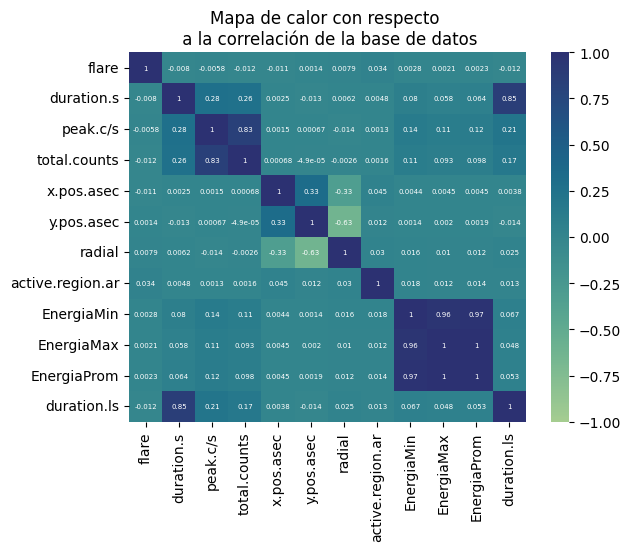

In [438]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''

matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5}
           ,vmin=-1,vmax=1)

<Figure size 640x480 with 0 Axes>

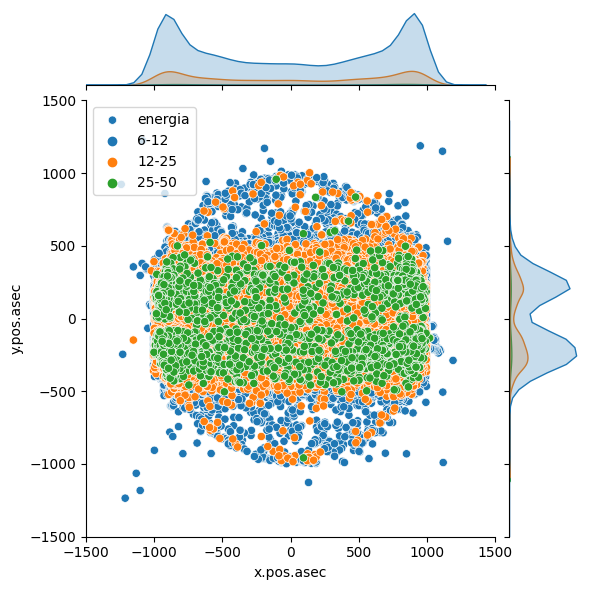

In [422]:
plt.figure()
sns.jointplot(dfe.sort_values('EnergiaProm'), x='x.pos.asec',y='y.pos.asec',kind='scatter',hue='energy.kev',xlim=(-1500,1500),ylim=(-1500,1500),label='energia')
plt.legend(loc='upper left')

In [474]:
#separacion por emisferios positivos para x,y
dfx=df[df['x.pos.asec'] > 0]
dfx=dfx[dfx['x.pos.asec'] < 1000]
dfy=df[df['y.pos.asec']> 0]
dfy=dfy[dfy['y.pos.asec']< 1000]
#dataframes en la posicion positiva en x (a la derecha del 0)
energypox1 = Filtro(dfx,'energy.kev','6-12')
energypox2 = Filtro(dfx,'energy.kev','12-25')
energypox3 = Filtro(dfx,'energy.kev','25-50')
energypox4 = Filtro(dfx,'energy.kev','25-100')
#dataframes en la posicion positiva de y (arriba de 0)
energypoy1 = Filtro(dfy,'energy.kev','6-12')
energypoy2 = Filtro(dfy,'energy.kev','12-25')
energypoy3 = Filtro(dfy,'energy.kev','25-50')
energypoy4 = Filtro(dfy,'energy.kev','25-100')

In [424]:
#sns.kdeplot(data=dffe.sort_values('EnergiaProm'),x='x.pos.asec',y='y.pos.asec',hue='energy.kev',xlim=(-1000,1000),ylim=(-1000,1000))

$$
\textbf{Prueba de hipotesis t de student y f de fisher para las duraciones}
$$
se realizan dos funciones en las que se trabajan unas pruebas de hipotesis con respecto a las distribuciones t de student y F de Fisher para determinar si hay una diferencia significativa entre las medias poblacionales y aunque en un principio se intentó con una t student la verdad es que la evaluación de su estadistico proporcionaba valores (pvalores, e intervalos) que en primer lugar carecian de sentido pues aunque los datos mostrabán unas diferencias con respecto a los valores de duracion promedio dependiendo de la energía, y se observa una independencia del promedio de estos valores entre los rangos energeticos (osea la duracion media de las llamaradas de cada valor de energia es independiente del resto de valores en los que no se encuentra)
al plantear la hipotesis nula en la que las medias poblacionales para los valores de energia eran iguales para la F de fisher se observó que el nivel de significancia fue muy bajo ademas que el estadistico de esta hipotesis , queda fuerá del intervalo de confianza. Por lo que se tienen suficientes argumentos para rechazar la hipotesis nula, se seleccionó la distribución F de fisher ya que se cumplen que las variables a evaluar (las duraciones de los distintos rangos de energia son variables aleatorias que se aproximan a una distribución chi-cuadrada), a continuacion se tienen unas graficas qq con respecto a la duración de las energias 1 y 2

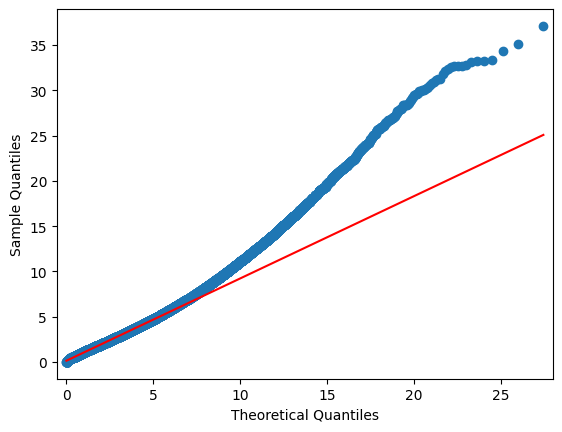

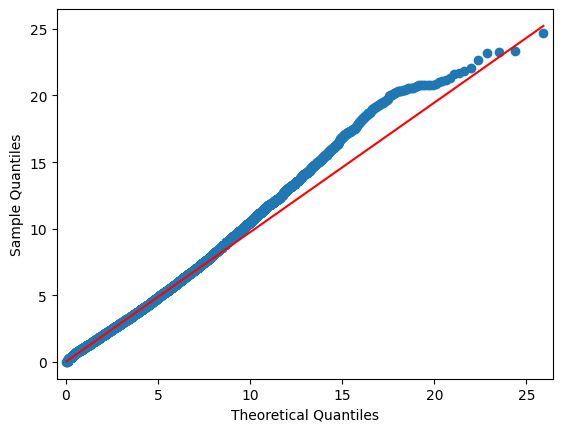

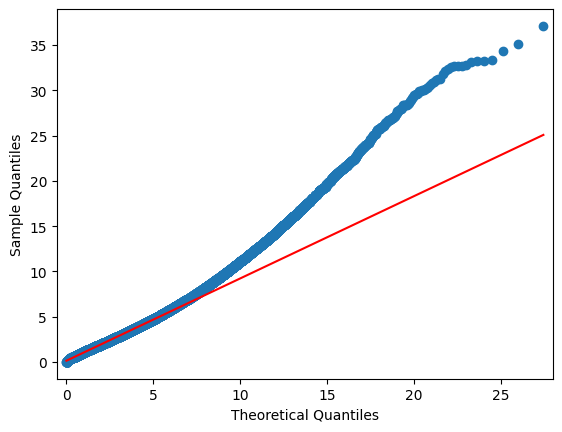

In [425]:
'''Graficas Q-Q '''
#q-q de la energia 2
sm.qqplot(data=energy2['duration.s'] , dist=stats.chi2, fit=True , line='q')
#q-q de la energia 1
sm.qqplot(data=energy1['duration.s'], dist=stats.chi2 , fit=True, line='q')

A continuación las graficas intercuantiles de las duraciones en segundos de las energias 25-50 , y 50-100 las cuales no se ajustan a la dist chi2 esto puede plantear que las duraciones tal vez no sigan una distribucion estadistica como tal, abusando del teorema del limite central se hacen q-q con respecto a la distribución normal aunque este no es un buen argumento para determinar si se ajustan a alguna distribucion pues tecnicamente al ser una muestra tan grande por el mismo teorema tiende a una distribucion normal

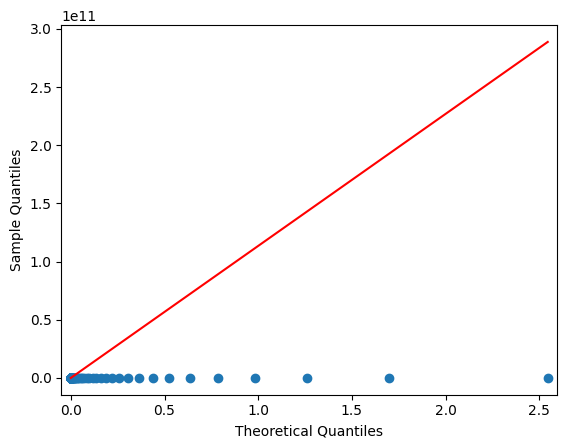

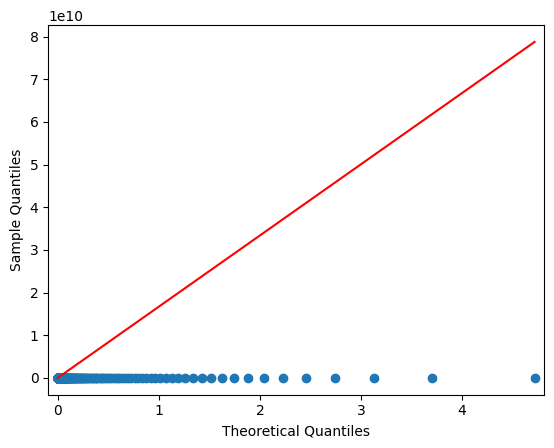

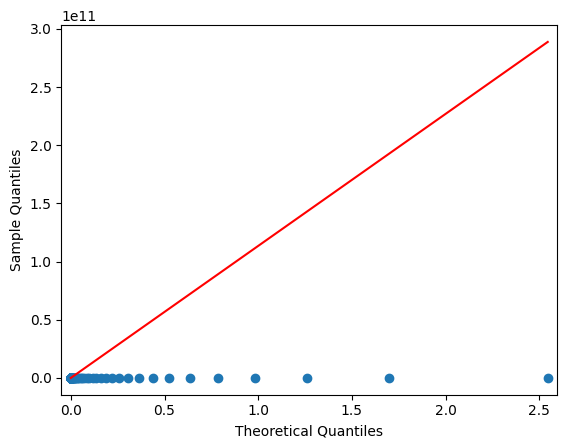

In [443]:
sm.qqplot(data=energy3['duration.s'] , dist=stats.chi2, fit=True , line='q')
sm.qqplot(data=energy4['duration.s'] , dist=stats.chi2 ,fit=True , line= 'q')

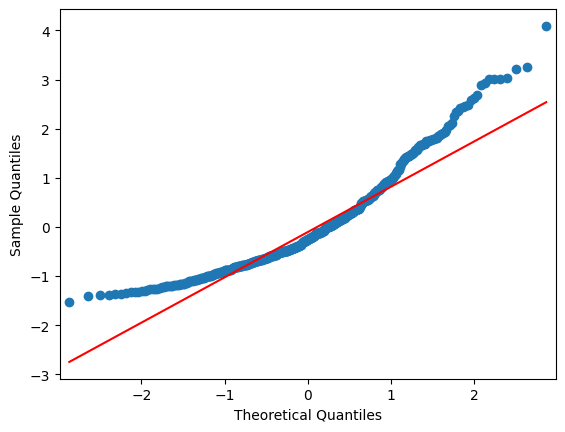

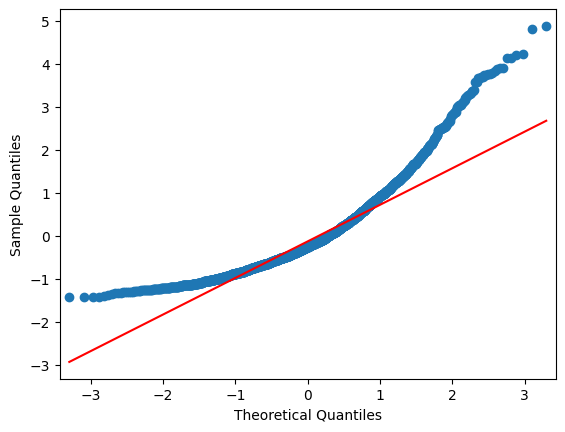

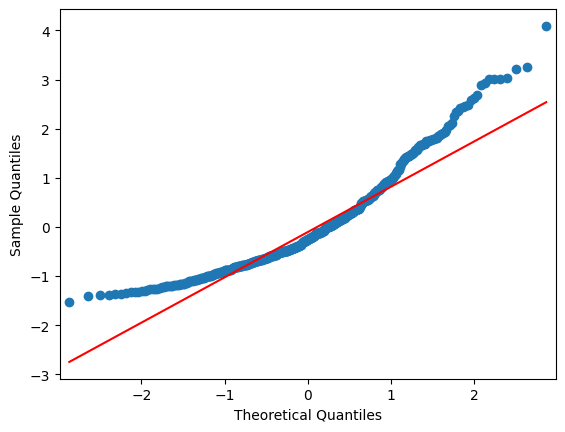

In [442]:
sm.qqplot(data=energy3['duration.s'] , dist=stats.norm ,fit=True , line= 'q')
sm.qqplot(data=energy4['duration.s'] , dist=stats.norm ,fit=True , line= 'q')

esto genera tal vez la sospecha de que las propias duraciones dependiendo del rango de energia tienen distribuciones distintas, esto justo puede tambien
puede llevar la discución a ciertas caracteristicas temporales de las llamaradas tales como el efecto nuepert que relaciona la forma funcional de las energias de rayos X de alta frecuencia es proporcional a la derivada temporal de la forma funcional de las llamaradas de energias con rayos X de baja frecuencias. Estas dos energias tienen una relación causal de la cual se habla en otras investigaciones.
$$
F(t)_{HXR}=\frac{\delta F(t)_{SHR}}{\delta t}
$$
En la siguiente celda se tienen las funciones para las pruebas estadisticas con respecto a las medias con la distribucion T de student, la prueba de proporcion de varianzas F de fisher y la prueba para un valor medio con la distribucion normal y aunque se tienen valores p 'positivos' realmente por la alta varianza de cada uno de los rangos no se puede confiar en ese ajuste

In [502]:
'''Funcion para prueba estadistica t student'''
def PDMT(dfa,dfb,col,alpha,hip):
# se sacan los promedios, el numero de muestras y las desviaciones estandar con n-1 grados de libertad 'ddof'
    proa=dfa[col].mean()
    prob=dfb[col].mean()
    na=len(dfa[col])
    nb=len(dfb[col])
    sta=dfa[col].std(ddof=(na-1))
    stb=dfb[col].std(ddof=(nb-1))
# se hace la diferencia de las medias muestrales y se calculan los grados de libertad para una t student de 
# dos variables aleatorios con varianzas diferentes y desconocidas esta se lleva al entero menor (aproximación de scatterhwaite)
    Promdif=prob-proa
    v=pow((pow(sta,2)/na)+(pow(stb,2)/nb),2)/((pow(pow(sta,2)/na,2)/na-1)+(pow(pow(stb,2)/nb,2)/nb-1))
    kv=int(v)
# se definen el t estadistico de la prueba Test y el valor critico de una distibucion t de student
# con kv grados de libertad , con un indice de sigfinicancia del 0.05 
    Tdeno=np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb))
    Tnume=(Promdif-hip)
    Test=Tnume/Tdeno
    conf=(1.0-alpha)
    cv=stats.t.ppf(conf, kv)
#intervalos de confianza a partir del valor v y se determina el valor estadistico p para la hipotesis nula de que mu_a=mu_b
    coin=Tnume-(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    coif=Tnume+(cv*np.sqrt((pow(sta,2)/na)+(pow(stb,2)/nb)))
    ps=1-sc.special.stdtr(kv,np.abs(Test))
    #p=(1.0-stats.t.cdf(np.abs(Test),kv))
    return Test, coin, coif, cv, ps, Promdif

'''Funcion prueba estadistica F de fisher'''
def PDVF(dfa,dfb,col,alpha):
# se definen las medias muestrales, el numero de muestras, los grados de libertad de cada muestra y las desviaciones estandar
# con los respectivos grados de libertad de las muestras
    pro1=dfa[col].mean()
    pro2=dfb[col].mean()
    n1=len(dfa[col])
    n2=len(dfb[col])
    dof1=(n1-1)
    dof2=(n2-1)
    st1=dfa[col].std(ddof=dof1)
    st2=dfb[col].std(ddof=dof2)
# grado de significancia alpha=0.025, intervalo de confianza, F valor critico, , F estadistico, y valor p 
    finf=(1/stats.f.ppf(alpha,dof1,dof2))
    fsup=(1/stats.f.ppf(1-alpha,dof1,dof2))
    Fest=pow(st1,2)/pow(st2,2)
    coin=Fest*finf
    coif=Fest*fsup
    pf=1-stats.f.cdf(abs(Fest),dof1,dof2)
    return coif, coin, Fest , pf ,fsup

'''Funcion prueba estadistica t student para una media de posicion'''
def PDMTU(dfa,col,alpha,hip):
    n=len(dfa[col])
    dof=n-1
    conf=1-alpha
    std=dfa[col].std(ddof=dof)
    prom=dfa[col].mean()
    cv=stats.t.ppf(conf,dof)
    Tden=std/np.sqrt(n)
    T=(prom-hip)/Tden
    p=1-stats.t.cdf(abs(T),dof)
    coin=prom-cv*(std/np.sqrt(n))
    coif=prom+cv*(std/np.sqrt(n))
    return cv, coin, coif, p ,T

'''funcion para calcular el valor critico chi-cuadrado para valores de libertad de la muestra para el analisis del error'''
def PERROR(dfa,col,alpha,chi):
    n=len(dfa[col])
    dof=n-1
    conf=alpha
    cv=stats.chi2.ppf(conf,dof)
    return cv

In [513]:
# pruebas estadisticas para la diferencia del valor medio de la duracion entre dos poblaciones categorizadas por su energia T de student 
# defina su hipotesis
hipt1=0
hipt2=400
# T test para energias 6-12 y 12-25 , 12-25 y 25-50
Test12, coin12, coif12, cv12, ps12, Promdif12=PDMT(energy1,energy2,'duration.s',0.025,hipt1)
Test23, coin23, coif23, cv23, ps23, Promdif23=PDMT(energy2,energy3,'duration.s',0.025,hipt1)
# pruebas estadisticas para la proporcion de las varianzas de dos poblaciones categorizadas por energia con F de fisher 
# pruebas F de fisher para energias 6-12 y 12-25 para las duraciones
coifdur12, coindur12, Festdur12 , pfdur12, fsupdur12 = PDVF(energy1,energy2,'duration.s',0.05)
coifdur23, coindur23, Festdur23 , pfdur23, fsupdur23 = PDVF(energy2,energy3,'duration.s',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en x
coifpx12, coinpx12, Festpx12 , pfpx12 ,fsupx12 = PDVF(energypox1,energypox2,'x.pos.asec',0.05)
coifpx23, coinpx23, Festpx23 , pfpx23 ,fsupx23 = PDVF(energypox2,energypox3,'x.pos.asec',0.05)
# pruebas F de fisher para energias 12-25 y 25-50 para las posiciones en y
coifpy12, coinpy12, Festpy12 , pfpy12 ,fsupy12 = PDVF(energypoy1,energypoy2,'y.pos.asec',0.05)
coifpy23, coinpy23, Festpy23 , pfpy23 ,fsupy23 = PDVF(energypoy2,energypoy3,'y.pos.asec',0.05)
# prueba estadistica t student para determinar la media de la posicion x de las energias 6-12 y 12-25
cvnpx1, coinpx1, coifpx1, ppx1 ,Tpx1 = PDMTU(energypox1,'x.pos.asec',0.025,hipt2)
cvnpx2, coinpx2, coifpx2, ppx2 ,Tpx2 = PDMTU(energypox2,'x.pos.asec',0.025,hipt2) 
# prueba estadistica t student para determinar la media de la posicion y de las energias 6-12 y 12-25
cvnpy1, coinpy1, coifpy1, ppy1, Tpy1 = PDMTU(energypoy1,'y.pos.asec',0.025,hipt2)
cvnpy2, coinpy2, coifpy2, ppy2, Tpy2 = PDMTU(energypoy2,'y.pos.asec',0.025,hipt2) 
#RESULTADOS ENERGIAS 6-12 12-25
print('T estadistico para las energias 6-12 y 12-25: ',Test12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coin12,',',coif12,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12 y 12-25:',cv12)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0)',ps12)

T estadistico para las energias 6-12 y 12-25:  0.5660985431428447  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( -899.0348482489873 , 1629.2607055237727 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12 y 12-25: 1.9600297844379175
valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0) 0.2856651584789349


In [514]:
#RESULTADOS ENERGIAS 12-25 25-50
print('T estadistico para las energias 12-25 y 25-50: ',Test23,' intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:(',coin23,',',coif23,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25 y 25-50:',cv23)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0)',ps23)

T estadistico para las energias 12-25 y 25-50:  0.27008850739923684  intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:( -1503.0216662204116 , 1983.33964066832 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25 y 25-50: 1.9604224112461393
valor p estadistica para la hipotesis nula 0 (la hipotesis nula es que las diferencia de las medias es 0) 0.39355146551817854


In [515]:
#Resultados Energias 6-12 12-25 para la duracion proporcion de varianzas F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Festdur12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifdur12,',',coindur12,')')
print('F critico para los grados de libertad de la muestra (chi cuadrada con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupdur12)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfdur12)

F estadistico para las energias 6-12 y 12-25:  1.6674203456843162  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 1.6369525203376012 , 1.6982451903376916 )
F critico para los grados de libertad de la muestra (chi cuadrada con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9817275677212569
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [516]:
#Resultados Energias 12-25 25-50 para la duracion proporcion de varianzas F de Fisher
print('F estadistico para las energias 12-25 y 25-50: ',Festdur23,' intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:(',coifdur23,',',coindur23,')')
print('F critico para los grados de libertad de las muestras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50:',fsupdur23)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfdur23)

F estadistico para las energias 12-25 y 25-50:  5.9117649237364125  intervalo de confianza con un 0.05 de significancia para enegias 12-25 y 25-50:( 5.597419645806051 , 6.235228973682124 )
F critico para los grados de libertad de las muestras (chi cuadradas con N-1 grados de libertad) para energias 12-25 y 25-50: 0.9468271688767208
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [517]:
#Resultados Energias 6-12 12-25 para la posicion x coon la proporcion de varianzas 1 para F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Festpx12,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifpx12,',',coinpx12,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupx12)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpx12)

F estadistico para las energias 6-12 y 12-25:  4.355125095114095  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 4.242957136243969 , 4.469161124899296 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9742446068894863
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [518]:
#Resultados Energias 12-25 25-50 para la posicion x con la proporcion de varianzas 1 para F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Festpx23,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifpx23,',',coinpx23,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupx23)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpx23)

F estadistico para las energias 6-12 y 12-25:  10.895507704103009  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 10.086168521740566 , 11.738096449785223 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25: 0.9257180845223335
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [519]:
#Resultados Energias 12-25 25-50 para la posicion y proporcion de varianzas F de Fisher
print('F estadistico para las energias 6-12 y 12-25: ',Tpx1,' intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:(',coifpy12,',',coinpy12,')')
print('F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25:',fsupy12)
print('valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1)',pfpy12)

F estadistico para las energias 6-12 y 12-25:  0.8838227434020917  intervalo de confianza con un 0.05 de significancia para enegias 6-12 y 12-25:( 5.077360400317481 , 5.374919365472877 )
F critico para los grados de libertad de las muesFestpx12tras (chi cuadradas con N-1 grados de libertad) para energias 6-12 y 12-25: 0.971776727938134
valor p estadistica para la hipotesis nula (la hipotesis nula es que las proporcion de las varianzas es 1) 1.1102230246251565e-16


In [521]:
#Resultados posicion x para las energias 6-12
print('T estadistico para las energias 6-12:',Tpx1,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpx1,',',coifpx1,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpx1)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppx1)

T estadistico para las energias 6-12: 0.8838227434020917  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( 89.3633356371264 , 1220.8554027673263 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.9600190029006381
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.18839841738567809


In [524]:
#Resultados posicion x para las energias 12-25
print('T estadistico para las energias 12-25:',Tpx2,' intervalo de confianza con un 0.05 de significancia para enegias 12-25:(',coinpx2,',',coifpx2,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25:',cvnpx2)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppx2)

T estadistico para las energias 12-25: 0.8364393832078986  intervalo de confianza con un 0.05 de significancia para enegias 12-25:( 74.94303997039526 , 1208.9488354733617 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 12-25: 1.9602046578583885
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.20146401947434733


In [527]:
#Resultados posicion y para las energias 6-12
print('T estadistico para las energias 6-12:',Tpy1,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpy1,',',coifpy1,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpy1)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppy1)

T estadistico para las energias 6-12: -1.3151655797348185  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( -7.050768817840208 , 480.14520296965503 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.9600258901004164
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.09423106475500753


In [528]:
#Resultados posicion y para las energias 12-25
print('T estadistico para las energias 6-12:',Tpy2,' intervalo de confianza con un 0.05 de significancia para enegias 6-12:(',coinpy2,',',coifpy2,')')
print('T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12:',cvnpy2)
print('valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400)',ppy2)

T estadistico para las energias 6-12: -1.4585045481043972  intervalo de confianza con un 0.05 de significancia para enegias 6-12:( -4.776553871027545 , 459.40684340332155 )
T critico para los grados de libertad de la muestra (T student con N-1 grados de libertad) para energias 6-12: 1.9602575893594263
valor p estadistica para la hipotesis nula 0 (la hipotesis nula de que el promedio poblacional es se encuentra alrededor de 400) 0.07237019325033511


Con lo anterior se pueden concluir la siguientes cosas con respecto a las pruebas realizadas para la distribucion T de student para las medias de las duraciones y es que aunque los valores den mayores a los de significancia esto es por que la varianza de los datos es extremadamente alta por lo que el intervalo de apreciación para los valores de la duracion se hace muy ancho por lo que las diferencias siempre quedan dentro del intervalo, esto muestra que no es un ajuste muy confiable para determinar tanto si son poblaciones con medias iguales o si quiera si son diferentes, al trabajar con una F de fisher la proporcion de las varianzas bajo la misma hipotesis nula si se puede obtener un resultado determinante pues los p valores de la prueba nos permiten rechazar la hipotesis en que las medias de las poblaciones son iguales o que la proporcion de sus varianzas es 1, con respecto a las pruebas t de student con respecto a las posicion x,y para determinar su media poblacional de las energias 6-12 , 12-25 es su intervalo de confianza y que la hipotesis nula (que el promedio es alrededor de 400) no puede ser rechazada.

$$
\textbf{Graficas aproximadas para las duraciones y posiciones de los rangos de energia 1,2 y 3}
$$

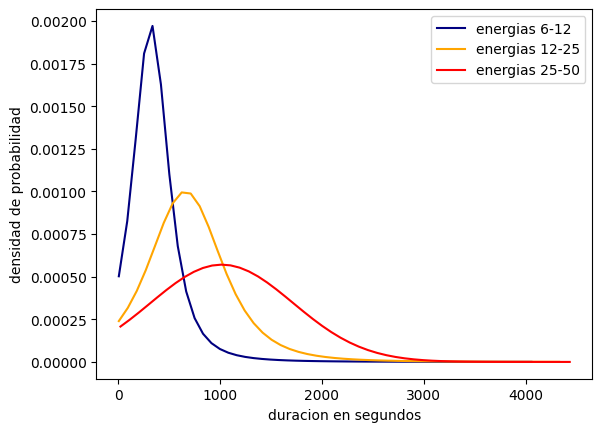

In [534]:
#Funcion que dibuja la curva aproximada dado un data frame la columna y la distribucion a la que se cree puede ajustarse
def AproxGra(dfa,col,dists):
    dist=dists
    freedom=len(dfa[col])-1
    paradist= dist.fit(data=dfa[col])
    xd=np.linspace(min(dfa[col]),max(dfa[col]))
    yd=dist.pdf(xd,*paradist)
    return xd, yd, paradist
# aproximacion de las duraciones para las energias 1,2 y 3 
x1,y1,p1 = AproxGra(energy1,'duration.s',stats.t)
x2,y2,p2 = AproxGra(energy2,'duration.s',stats.t)
x3,y3,p3 = AproxGra(energy3,'duration.s',stats.t)
# aproximacion las posiciones x para las energias 1,2 y 3 
xpos1,ypos1,px1par = AproxGra(energypox1,'x.pos.asec',stats.norm)
xpos2,ypos2,px2par = AproxGra(energypox2,'x.pos.asec',stats.norm)
xpos3,ypos3,px3par = AproxGra(energypox3,'x.pos.asec',stats.norm)
# aproximacion de las posiciones en y para las energias 1,2 y 3
xposy1,yposy1,px1pary = AproxGra(energypoy1,'y.pos.asec',stats.norm)
xposy2,yposy2,px2pary = AproxGra(energypoy2,'y.pos.asec',stats.norm)
xposy3,yposy3,px3pary = AproxGra(energypoy3,'y.pos.asec',stats.norm)
#grafica de la aproximacion de la duracion
plt.figure()
plt.plot(x1,y1,label='energias 6-12',color='navy')
plt.plot(x2,y2,label='energias 12-25',color='orange')
plt.plot(x3,y3,label='energias 25-50',color='red')
plt.ylabel('densidad de probabilidad')
plt.xlabel('duracion en segundos')
plt.legend()

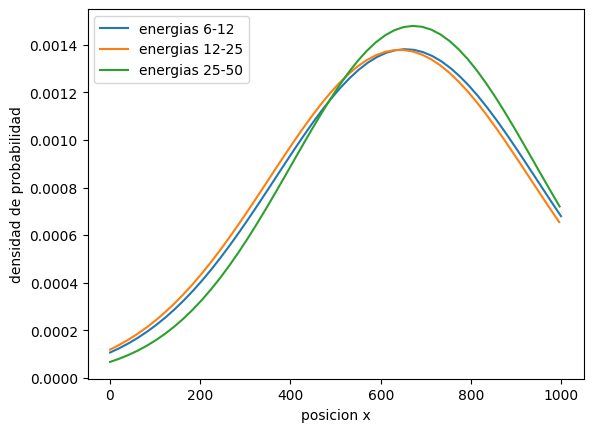

In [533]:
#sns.histplot(data=energy1,x='duration.s')
plt.figure()
plt.plot(xpos1,ypos1,label='energias 6-12')
plt.plot(xpos2,ypos2,label='energias 12-25')
plt.plot(xpos3,ypos3,label='energias 25-50')
plt.legend()
plt.ylabel('densidad de probabilidad')
plt.xlabel('posicion x')
plt.show()

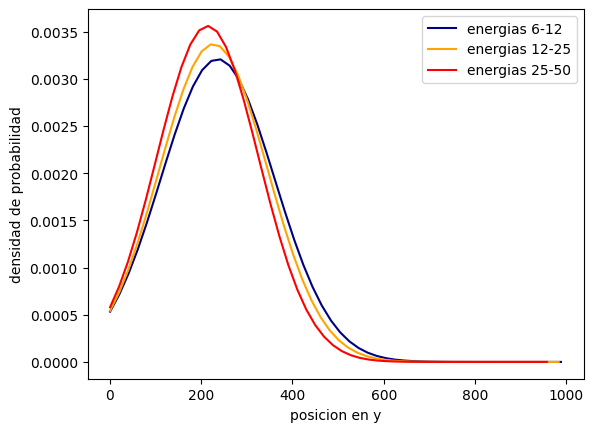

In [536]:
plt.figure()
plt.plot(xposy1,yposy1,label='energias 6-12',color='navy')
plt.plot(xposy2,yposy2,label='energias 12-25',color='orange')
plt.plot(xposy3,yposy3,label='energias 25-50',color='red')
plt.ylabel('densidad de probabilidad')
plt.xlabel('posicion en y')
plt.legend()

In [539]:
ErrorEnergy1=energy1.sort_values(ascending=True,by='duration.s')
chi1=[]
ListaEnergy1=ErrorEnergy1['duration.s']
for i in range(min(ErrorEnergy1['duration.s']),max(ErrorEnergy1['duration.s'])):
    chi=pow(ListaEnergy1[i]-y1,2)/(ListaEnergy1[i])
chi2=chi.sum()
error=PERROR(ErrorEnergy1,'duration.s',0.05,chi2)
print(error,chi2)

86273.18169853902 4199.977806321016


$$
\textit{Analisis Exploratorio de datos filtrados por flags}
$$

In [431]:
#dffiltro
'''
funciones
PDMT
PDVF
PDMTU
AproxGra
'''

dffiltrox=dffiltro[dffiltro['x.pos.asec'] > 0]
dffiltrox=dffiltrox[dffiltrox['x.pos.asec'] < 1000]
dffiltroy=dffiltro[dffiltro['y.pos.asec']> 0]
dffiltroy=dffiltroy[dffiltroy['y.pos.asec']< 1000]

filenergypox1 = Filtro(dffiltrox,'energy.kev','6-12')
filenergypox2 = Filtro(dffiltrox,'energy.kev','12-25')
filenergypox3 = Filtro(dffiltrox,'energy.kev','25-50')
filenergypox4 = Filtro(dffiltrox,'energy.kev','25-100')

filenergypoy1 = Filtro(dffiltroy,'energy.kev','6-12')
filenergypoy2 = Filtro(dffiltroy,'energy.kev','12-25')
filenergypoy3 = Filtro(dffiltroy,'energy.kev','25-50')
filenergypoy4 = Filtro(dffiltroy,'energy.kev','25-100')

filenergy1 = Filtro(dffiltro,'energy.kev','6-12')
filenergy2 = Filtro(dffiltro,'energy.kev','12-25')
filenergy3 = Filtro(dffiltro,'energy.kev','25-50')
filenergy4 = Filtro(dffiltro,'energy.kev','50-100')

PruebaFiltradaDuracion=PDMT(dffiltro,filenergy2,'duration.s',0.025,0)
PruebaFiltradaDuracionF=PDVF(dffiltro,filenergy2,'duration.s',0.025)
PruebaFiltradaPosXN=PDMTU(filenergypox1,'x.pos.asec', 0.025,230)
PruebaFiltradaPosYN=PDMTU(filenergypoy1,'y.pos.asec', 0.025,450)
PruebaFiltradaPosXT=PDMT(filenergypoy1,filenergypoy2,'y.pos.asec',0.025,1000)

#sm.qqplot(data=filenergy4['duration.s'] , dist=stats.chi2, fit=True , line='q')
print(PruebaFiltradaDuracion)
print(PruebaFiltradaDuracionF)
print(PruebaFiltradaPosXN)
print(PruebaFiltradaPosXT)

(0.4103170400777043, -1002.3619322554961, 1533.1367577364863, 1.9600747203027769, 0.3407887484035468, 265.38741274049505)
(3.4687630978378596, 3.698589357654187, 3.5824938686592036, 1.1102230246251565e-16)
(1.96008613553181, 80.7265732422834, 1222.3077674877788, 0.0738888498251371)
(-5.6586911322608175, -1355.230841094039, -657.8917695915902, 1.9601520539009598, 7.792625100755401e-09, -6.561305342814592)


In [432]:
Xposxfil1,Xposyfil1, Xpfil1=AproxGra(filenergypox1,'x.pos.asec',stats.norm)
Yposxfil1,Yposyfil1, Ypfil1=AproxGra(filenergypoy1,'y.pos.asec',stats.norm)
durxfil1,duryfil1, durpfil1=AproxGra(filenergy1,'duration.s',stats.t)
#plt.plot(Xposxfil1,Xposyfil1)

In [433]:
#plt.plot(Yposxfil1,Yposyfil1)

In [434]:
#sns.histplot(data=dffiltroy,x='y.pos.asec',hue='energy.kev')

39017.944730266456 5799.902804019466
